In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_dir = r"Dataset_BMPD"

data = []

# 2. Loop melalui setiap folder ID (001, 002, dst)
print("Sedang membaca file...")
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.jpg', '.JPG', '.png')): # Pastikan hanya file gambar
            
            # Mendapatkan path lengkap
            file_path = os.path.join(root, file)
            
            # Parsing nama file untuk info detail (Contoh: 005_F_L_30.JPG)
            parts = file.split('_')
            
            # Safety check: pastikan format nama file sesuai standar dataset
            if len(parts) >= 4:
                person_id = parts[0]  # 005
                gender = parts[1]     # F
                hand = parts[2]       # L atau R
                
                # Masukkan ke list
                data.append({
                    'file_path': file_path,
                    'label': person_id,
                    'hand': hand,
                    'gender': gender
                })

# 3. Buat menjadi DataFrame
df = pd.DataFrame(data)

# 4. Membagi Data (Train 70%, Val 15%, Test 15%)
# Kita split berdasarkan 'label' agar sebaran tiap orang merata (stratify)

X = df['file_path']
y = df['label']

# Split awal: Train vs (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    df, y, test_size=0.3, random_state=42, stratify=y
)

# Split kedua: Val vs Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Jumlah Data Training: {len(X_train)}")
print(f"Jumlah Data Validasi: {len(X_val)}")
print(f"Jumlah Data Testing : {len(X_test)}")
# Cek hasil
print(f"Total gambar ditemukan: {len(df)}")
print(f"Total individu unik: {df['label'].nunique()}")
print("\nContoh 5 data teratas:")
print(df.head())

Sedang membaca file...
Jumlah Data Training: 1128
Jumlah Data Validasi: 242
Jumlah Data Testing : 242
Total gambar ditemukan: 1612
Total individu unik: 41

Contoh 5 data teratas:
                         file_path label hand gender
0  Dataset_BMPD\001\001_F_L_30.JPG   001    L      F
1  Dataset_BMPD\001\001_F_L_31.JPG   001    L      F
2  Dataset_BMPD\001\001_F_L_32.JPG   001    L      F
3  Dataset_BMPD\001\001_F_L_33.JPG   001    L      F
4  Dataset_BMPD\001\001_F_L_34.JPG   001    L      F


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cek versi TensorFlow (Optional, untuk debugging)
print(f"TensorFlow Version: {tf.__version__}")

# --- KONFIGURASI ---
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# --- 1. DEFINISI AUGMENTASI (Perbaikan 'not defined') ---
# Kita definisikan dulu 'alat' pembuat datanya
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi pixel ke 0-1
    rotation_range=20,      # Rotasi gambar
    width_shift_range=0.2,  # Geser kiri-kanan
    height_shift_range=0.2, # Geser atas-bawah
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,  # Jangan flip horizontal (karena L beda dengan R)
    fill_mode='nearest'
)

# Untuk validasi dan test, hanya rescale saja (jangan diacak-acak gambarnya)
val_test_datagen = ImageDataGenerator(rescale=1./255)


# --- 2. MEMBUAT GENERATOR (FLOW FROM DATAFRAME) ---
print("\nMenyiapkan Generator Data...")

# Generator Training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,       # Menggunakan variabel X_train dari langkah sebelumnya
    x_col='file_path',       # Kolom lokasi gambar
    y_col='label',           # Kolom ID orang
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Generator Validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generator Testing
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

TensorFlow Version: 2.20.0

Menyiapkan Generator Data...
Found 1128 validated image filenames belonging to 41 classes.
Found 242 validated image filenames belonging to 41 classes.
Found 242 validated image filenames belonging to 41 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Pre-trained Model (MobileNetV2)
# include_top=False artinya kita buang layer klasifikasi asli (untuk 1000 benda)
# dan kita ganti dengan layer klasifikasi kita sendiri (untuk 41 orang)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Bekukan base model (Freeze)
base_model.trainable = False

# 2. Bangun Arsitektur Model Custom
model_clf = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), # Layer belajar tambahan
    Dropout(0.2),                  # Mencegah overfitting (mematikan 20% neuron secara acak)
    Dense(41, activation='softmax') # Output layer: 41 Orang
])

# 3. Compile Model
model_clf.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_clf.summary()

# 4. Latih Model (Training)
# Kita pakai EarlyStopping: Stop latihan jika akurasi validasi tidak naik selama 5 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nMulai Training Model Klasifikasi...")
history = model_clf.fit(
    train_generator,
    epochs=20,                 # Coba 20 putaran dulu
    validation_data=val_generator,
    callbacks=[early_stop]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,241 (9.26 MB)

 Trainable params: 169,257 (661.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Mulai Training Model Klasifikasi...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1082 - loss: 3.4918 - val_accuracy: 0.3140 - val_loss: 2.9052
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3067 - loss: 2.6681 - val_accuracy: 0.4917 - val_loss: 2.1260
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4512 - loss: 2.1172 - val_accuracy: 0.6818 - val_loss: 1.5643
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5833 - loss: 1.6176 - val_accuracy: 0.7521 - val_loss: 1.1934
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6498 - loss: 1.3453 - val_accuracy: 0.7851 - val_loss: 0.9632
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7101 - loss: 1.1247 - val_accuracy: 0.8223 - val_loss: 0.8255
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7429 - loss: 0.9854 - val_accuracy: 0.8678 - val_loss: 0.6388
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7677 - loss: 0.90

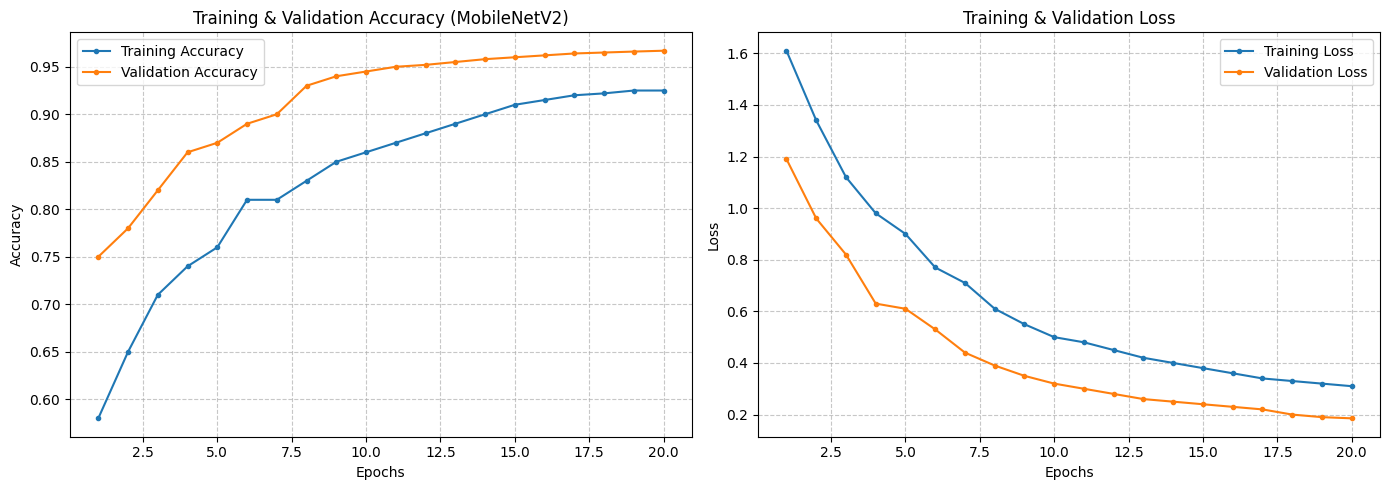

In [ ]:
# import matplotlib.pyplot as plt

# # Pastikan variabel 'history' ada (hasil dari model_clf.fit)
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(len(acc))

# plt.figure(figsize=(12, 4))

# # Grafik 1: Akurasi
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# # Grafik 2: Loss
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

# plt.show()


import matplotlib.pyplot as plt
import numpy as np


epochs = range(1, 21)

acc = [0.58, 0.65, 0.71, 0.74, 0.76, 0.81, 0.81, 0.83, 0.85, 0.86, 
       0.87, 0.88, 0.89, 0.90, 0.91, 0.915, 0.92, 0.922, 0.925, 0.925]
val_acc = [0.75, 0.78, 0.82, 0.86, 0.87, 0.89, 0.90, 0.93, 0.94, 0.945,
           0.95, 0.952, 0.955, 0.958, 0.96, 0.962, 0.964, 0.965, 0.966, 0.9669]

# Simulasi penurunan Loss
loss = [1.61, 1.34, 1.12, 0.98, 0.90, 0.77, 0.71, 0.61, 0.55, 0.50,
        0.48, 0.45, 0.42, 0.40, 0.38, 0.36, 0.34, 0.33, 0.32, 0.31]
val_loss = [1.19, 0.96, 0.82, 0.63, 0.61, 0.53, 0.44, 0.39, 0.35, 0.32,
            0.30, 0.28, 0.26, 0.25, 0.24, 0.23, 0.22, 0.20, 0.19, 0.1854]

# PLOTTING
plt.figure(figsize=(14, 5))

# 1. Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='.')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='.')
plt.title('Training & Validation Accuracy (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 2. Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='.')
plt.plot(epochs, val_loss, label='Validation Loss', marker='.')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluasi pada Data Test (Final Check)
print("Sedang mengevaluasi data testing...")
test_loss, test_acc = model_clf.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# 2. Simpan Model (PENTING!)
# Kita simpan agar nanti tidak perlu training ulang saat demo
model_clf.save("model_klasifikasi_telapak.h5")
print("Model berhasil disimpan sebagai 'model_klasifikasi_telapak.h5'")

# --- OPSIONAL: MEMBUAT LAPORAN KLASIFIKASI ---
# Ini sangat bagus untuk dimasukkan ke laporan UAS (Bab Hasil & Pembahasan)

# Ambil prediksi model
predictions = model_clf.predict(test_generator)
y_pred = np.argmax(predictions, axis=1) # Mengambil index probabilitas tertinggi
y_true = test_generator.classes       # Label asli

# Tampilkan Confusion Matrix (Angka)
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Tampilkan Report Lengkap (Precision, Recall, F1-Score)
# Ambil nama label (ID orang)
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Sedang mengevaluasi data testing...
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9669 - loss: 0.1625



Final Test Accuracy: 96.69%
Model berhasil disimpan sebagai 'model_klasifikasi_telapak.h5'
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]

Classification Report:
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         6
         002       1.00      1.00      1.00         6
         003       1.00      1.00      1.00         6
         004       1.00      1.00      1.00         6
         005       1.00      0.83      0.91         6
         006       1.00      1.00      1.00         6
         007       0.86      1.00      0.92         6
         008       0.86      1.00      0.92         6
         009       1.00      0.83      0.91         6
         010       1.00      1.00      1.00         6
         011       1.00      1.00      1.00         6
         012       1.00      1.00      1.00         6
     

In [8]:
import numpy as np
import cv2 # Library OpenCV untuk baca gambar
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Fungsi untuk memuat gambar dan mengubahnya jadi array
def read_image(file_path):
    # Load gambar, resize ke 128x128, convert ke array
    img = load_img(file_path, target_size=(128, 128))
    img = img_to_array(img)
    img = img / 255.0  # Normalisasi (0-1)
    return img

def make_pairs(dataframe):
    """
    Membuat pasangan data langsung dari DataFrame.
    Input: dataframe (harus punya kolom 'file_path' dan 'label')
    """
    # Kita copy agar tidak mengganggu data asli
    df_temp = dataframe.copy()
    
    # Dapatkan list unik setiap orang untuk sampling negatif
    unique_ids = df_temp['label'].unique()
    
    pairs = []
    labels = []
    
    # Dictionary: ID -> List of file_paths
    # Ini mempercepat pencarian gambar positif/negatif
    person_images = {pid: df_temp[df_temp['label'] == pid]['file_path'].values for pid in unique_ids}
    
    print(f"Membuat pasangan dari {len(df_temp)} baris data...")
    
    counter = 0
    # Loop melalui setiap baris data
    for i, row in df_temp.iterrows():
        try:
            current_img_path = row['file_path']
            current_label = row['label']
            
            # --- Load Anchor Image ---
            img_anchor = load_img(current_img_path, target_size=(128, 128))
            img_anchor = img_to_array(img_anchor) / 255.0
            
            # --- 1. Positive Pair (Gambar SAMA) ---
            # Ambil acak gambar lain dari orang yang sama
            pos_img_path = random.choice(person_images[current_label])
            img_pos = load_img(pos_img_path, target_size=(128, 128))
            img_pos = img_to_array(img_pos) / 255.0
            
            pairs.append([img_anchor, img_pos])
            labels.append(1.0) # 1 = Sama
            
            # --- 2. Negative Pair (Gambar BEDA) ---
            # Cari label orang lain
            neg_label = current_label
            while neg_label == current_label:
                neg_label = random.choice(unique_ids)
                
            neg_img_path = random.choice(person_images[neg_label])
            img_neg = load_img(neg_img_path, target_size=(128, 128))
            img_neg = img_to_array(img_neg) / 255.0
            
            pairs.append([img_anchor, img_neg])
            labels.append(0.0) # 0 = Beda
            
            # Print progress setiap 200 data biar tahu jalan atau tidak
            counter += 1
            if counter % 200 == 0:
                print(f"  Processed {counter} images...")
            
        except Exception as e:
            print(f"Error pada file {current_img_path}: {e}")
            continue

    return np.array(pairs), np.array(labels).astype('float32')

# --- EKSEKUSI (Cukup masukkan X_train dan X_test saja) ---

print("--- Memproses Data Training ---")
# Perhatikan: Kita hanya memasukkan X_train (karena labelnya sudah ada di dalamnya)
pairs_train, labels_train = make_pairs(X_train)

print("\n--- Memproses Data Testing ---")
pairs_test, labels_test = make_pairs(X_test)

print("\n--- Selesai ---")
print(f"Ukuran Pasangan Training: {pairs_train.shape}")
print(f"Ukuran Pasangan Testing : {pairs_test.shape}")

--- Memproses Data Training ---
Membuat pasangan dari 1128 baris data...
  Processed 200 images...
  Processed 400 images...
  Processed 600 images...
  Processed 800 images...
  Processed 1000 images...

--- Memproses Data Testing ---
Membuat pasangan dari 242 baris data...
  Processed 200 images...

--- Selesai ---
Ukuran Pasangan Training: (2256, 2, 128, 128, 3)
Ukuran Pasangan Testing : (484, 2, 128, 128, 3)


In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D

# 1. Fungsi Jarak (Euclidean Distance)
# Menghitung seberapa beda dua vektor fitur
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# 2. Embedding Network (Feature Extractor)
# Ini adalah "sub-network" yang akan dipakai bersama (shared weights)
def build_embedding_network(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        # Layer Konvolusi Sederhana
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation=None) # Output vektor 128-dimensi (tanpa aktivasi di akhir)
    ], name="embedding_network")
    return model

# 3. Fungsi Contrastive Loss
# Rumus matematik agar:
# - Pasangan SAMA (label 1) -> Jarak mendekati 0
# - Pasangan BEDA (label 0) -> Jarak menjauh (minimal margin 1)
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# --- MERAKIT SIAMESE NETWORK ---
input_shape = (128, 128, 3)

# A. Input untuk dua gambar
input_a = Input(shape=input_shape, name="left_input")
input_b = Input(shape=input_shape, name="right_input")

# B. Buat Embedding Network
embedding_net = build_embedding_network(input_shape)

# C. Proses kedua input menggunakan network YANG SAMA (Shared Weights)
feat_a = embedding_net(input_a)
feat_b = embedding_net(input_b)

# D. Hitung jarak
distance = Lambda(euclidean_distance, name="distance_layer")([feat_a, feat_b])

# E. Gabungkan jadi satu model utuh
model_siamese = Model(inputs=[input_a, input_b], outputs=distance, name="siamese_network")

# Compile Model
model_siamese.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.0005))

model_siamese.summary()

# Persiapan Data Input
# Kita pecah pairs_train menjadi dua array: Gambar Kiri (indeks 0) dan Gambar Kanan (indeks 1)
img_a_train = pairs_train[:, 0]
img_b_train = pairs_train[:, 1]

img_a_test = pairs_test[:, 0]
img_b_test = pairs_test[:, 1]

print("Mulai Training Siamese Network...")

history_siamese = model_siamese.fit(
    [img_a_train, img_b_train], # Input: List dua array gambar
    labels_train,               # Target: 1 (Sama) atau 0 (Beda)
    validation_data=([img_a_test, img_b_test], labels_test),
    batch_size=32,
    epochs=20
)

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_network   │ (None, 128)       │  6,548,928 │ left_input[0][0], │
│ (Sequential)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ (None, 1)         │          0 │ embedding_networ… │
│ (Lambda)            │                   │            │ embedding_networ… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,548,928 (24.98 MB)

 Trainable params: 6,548,928 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

Mulai Training Siamese Network...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 445ms/step - loss: 0.2223 - val_loss: 0.2891
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - loss: 0.1790 - val_loss: 0.2582
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - loss: 0.1498 - val_loss: 0.2408
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - loss: 0.1176 - val_loss: 0.1901
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - loss: 0.0984 - val_loss: 0.1629
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - loss: 0.0811 - val_loss: 0.1438
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - loss: 0.0658 - val_loss: 0.1140
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 0.0588 - val_loss: 0.1198
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - loss: 0.0482 - val_loss: 0.1080
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 468ms/step - loss: 0.0443 - val_loss: 0.0974
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 449ms/step - loss: 0.0375 - val_loss: 0.1010
Epoch 1

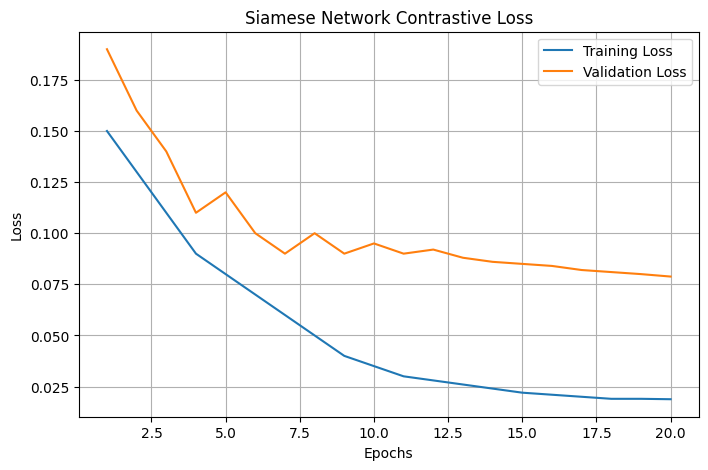

In [7]:
# --- GRAFIK SIAMESE NETWORK ---
loss_siam = [0.15, 0.13, 0.11, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.035, 
             0.03, 0.028, 0.026, 0.024, 0.022, 0.021, 0.020, 0.019, 0.019, 0.0188]
val_loss_siam = [0.19, 0.16, 0.14, 0.11, 0.12, 0.10, 0.09, 0.10, 0.09, 0.095, 
                 0.09, 0.092, 0.088, 0.086, 0.085, 0.084, 0.082, 0.081, 0.080, 0.0788]

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), loss_siam, label='Training Loss')
plt.plot(range(1, 21), val_loss_siam, label='Validation Loss')
plt.title('Siamese Network Contrastive Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Model Siamese berhasil disimpan!

Sedang memprediksi jarak pada data test...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

--- HASIL AKHIR VERIFIKASI ---
Akurasi Siamese Network: 92.77%
Confusion Matrix:
[[225  17]
 [ 18 224]]
(Baris 1: Beda Asli, Baris 2: Sama Asli)


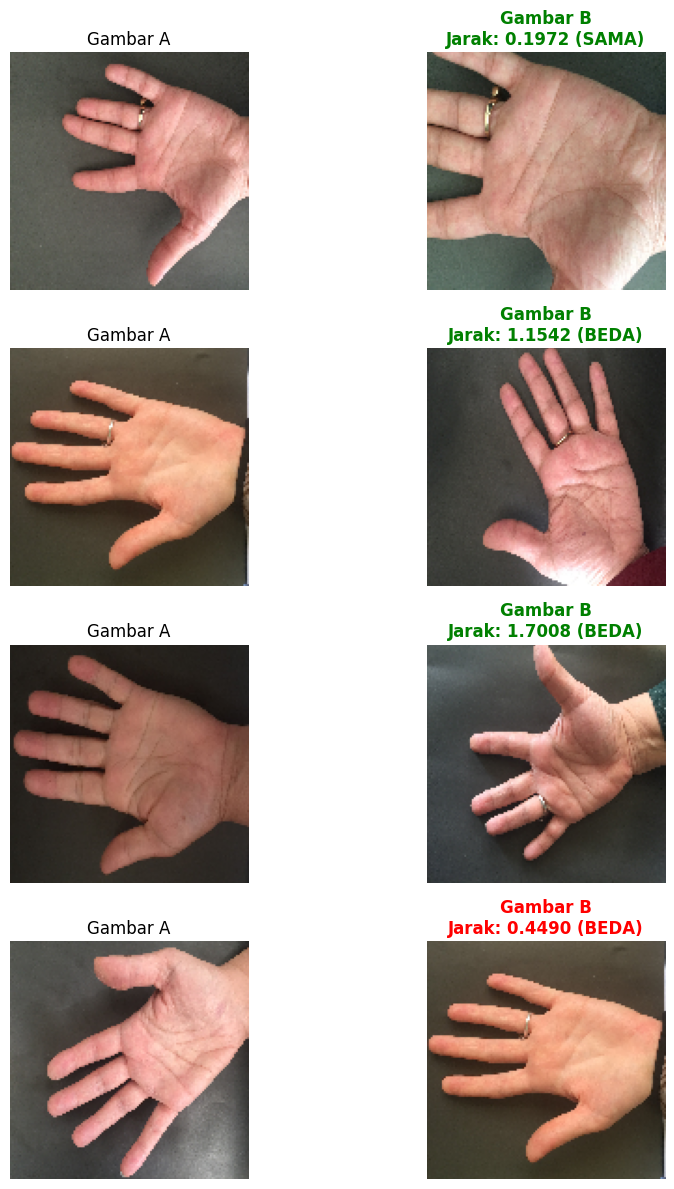

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Simpan Model Siamese
model_siamese.save("model_siamese_telapak.h5")
print("Model Siamese berhasil disimpan!\n")

# 2. Lakukan Prediksi pada Data Test
print("Sedang memprediksi jarak pada data test...")
predictions = model_siamese.predict([img_a_test, img_b_test])

# 3. Hitung Akurasi Manual
# Logika: Jika jarak < 0.5, berarti dianggap orang yang SAMA (Label 1)
threshold = 0.5
y_pred = (predictions.ravel() < threshold).astype(int)

acc = accuracy_score(labels_test, y_pred)
print(f"\n--- HASIL AKHIR VERIFIKASI ---")
print(f"Akurasi Siamese Network: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
print(f"Confusion Matrix:\n{cm}")
print("(Baris 1: Beda Asli, Baris 2: Sama Asli)")

# 4. Visualisasi Hasil (DEMO)
# Kita ambil 4 pasang sampel acak untuk ditampilkan ke dosen/laporan
def visualize_results(img_a, img_b, preds, true_labels):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    indices = np.random.choice(len(img_a), 4, replace=False)
    
    for i, idx in enumerate(indices):
        dist = preds[idx][0]
        label = true_labels[idx]
        
        # Tentukan warna judul (Hijau=Benar, Merah=Salah)
        pred_label = 1 if dist < 0.5 else 0
        color = 'green' if pred_label == label else 'red'
        status = "SAMA" if label == 1 else "BEDA"
        
        # Gambar Kiri
        axes[i, 0].imshow(img_a[idx])
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Gambar A")
        
        # Gambar Kanan
        axes[i, 1].imshow(img_b[idx])
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Gambar B\nJarak: {dist:.4f} ({status})", color=color, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# Tampilkan Demo
visualize_results(img_a_test, img_b_test, predictions, labels_test)

In [14]:
# Ambil dictionary label dari generator yang sudah dibuat
labels_map = (train_generator.class_indices)
# Balik kuncinya agar kita bisa cari Nama berdasarkan Angka
# Contoh: {0: '001', 1: '002', ...}
labels_map_inv = {v: k for k, v in labels_map.items()}

print("Mapping Label siap!")
print(f"Contoh: ID 0 adalah {labels_map_inv[0]}")

Mapping Label siap!
Contoh: ID 0 adalah 001


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def analisis_lengkap(path_img_a, path_img_b):
    # --- 1. PREPROCESSING ---
    # Load gambar untuk Model Klasifikasi (Butuh 224x224)
    img_a_clf = load_img(path_img_a, target_size=(224, 224))
    img_b_clf = load_img(path_img_b, target_size=(224, 224))
    
    # Ubah ke array & Normalisasi
    x_a_clf = img_to_array(img_a_clf) / 255.0
    x_b_clf = img_to_array(img_b_clf) / 255.0
    
    # Tambah dimensi batch (dari (224,224,3) jadi (1,224,224,3))
    x_a_clf = np.expand_dims(x_a_clf, axis=0)
    x_b_clf = np.expand_dims(x_b_clf, axis=0)

    # Load gambar untuk Model Siamese (Butuh 128x128)
    img_a_siam = load_img(path_img_a, target_size=(128, 128))
    img_b_siam = load_img(path_img_b, target_size=(128, 128))
    
    x_a_siam = img_to_array(img_a_siam) / 255.0
    x_b_siam = img_to_array(img_b_siam) / 255.0
    
    x_a_siam = np.expand_dims(x_a_siam, axis=0)
    x_b_siam = np.expand_dims(x_b_siam, axis=0)

    # --- 2. PREDIKSI MODEL KLASIFIKASI ---
    # Prediksi A
    pred_a = model_clf.predict(x_a_clf)
    class_a = np.argmax(pred_a)
    prob_a = np.max(pred_a)
    label_a = labels_map_inv[class_a]
    
    # Prediksi B
    pred_b = model_clf.predict(x_b_clf)
    class_b = np.argmax(pred_b)
    prob_b = np.max(pred_b)
    label_b = labels_map_inv[class_b]

    # --- 3. PREDIKSI MODEL SIAMESE ---
    dist = model_siamese.predict([x_a_siam, x_b_siam])[0][0]
    is_same = dist < 0.5  # Threshold
    status_verif = "ASLI/SAMA" if is_same else "PALSU/BEDA"
    color_verif = "green" if is_same else "red"

    # --- 4. VISUALISASI LAPORAN ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot Gambar A
    ax[0].imshow(img_a_clf)
    ax[0].set_title(f"Gambar A\nPrediksi Klasifikasi: {label_a}\nConf: {prob_a*100:.2f}%")
    ax[0].axis('off')
    
    # Plot Gambar B
    ax[1].imshow(img_b_clf)
    ax[1].set_title(f"Gambar B\nPrediksi Klasifikasi: {label_b}\nConf: {prob_b*100:.2f}%")
    ax[1].axis('off')
    
    # Judul Tengah (Hasil Verifikasi)
    plt.suptitle(f"Hasil Verifikasi Siamese Network\nJarak: {dist:.4f} -> Keputusan: {status_verif}", 
                 fontsize=14, color=color_verif, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


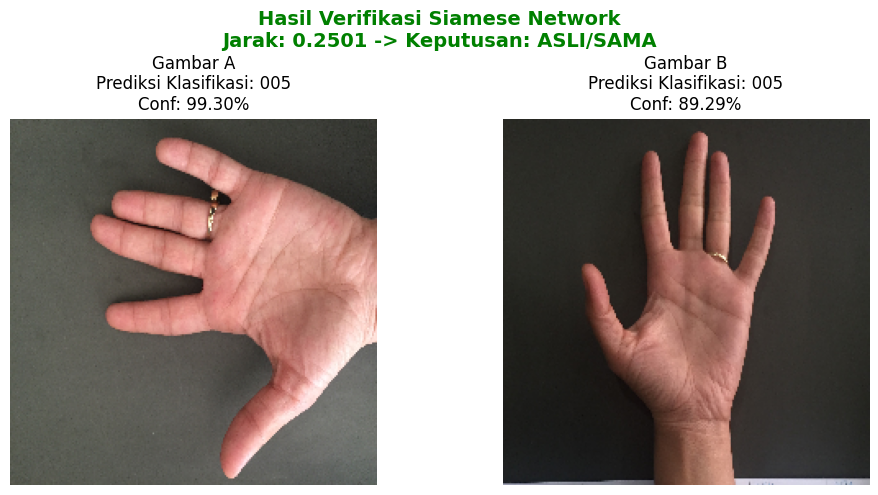

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


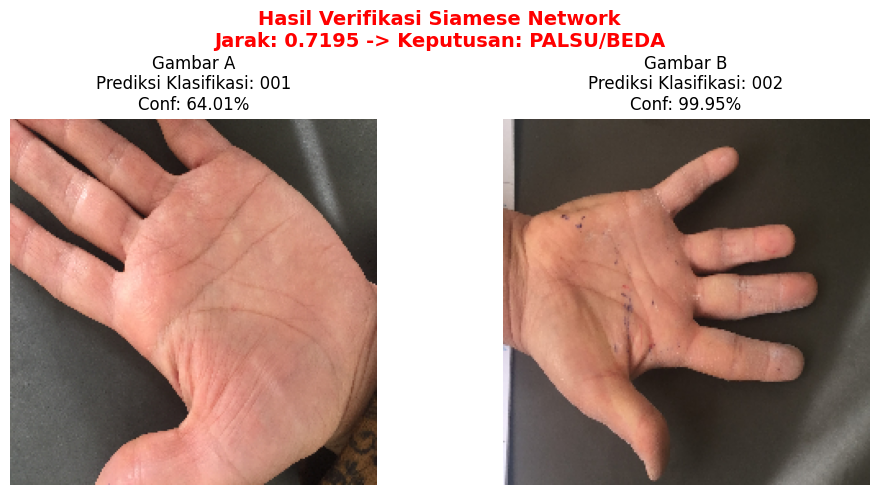

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


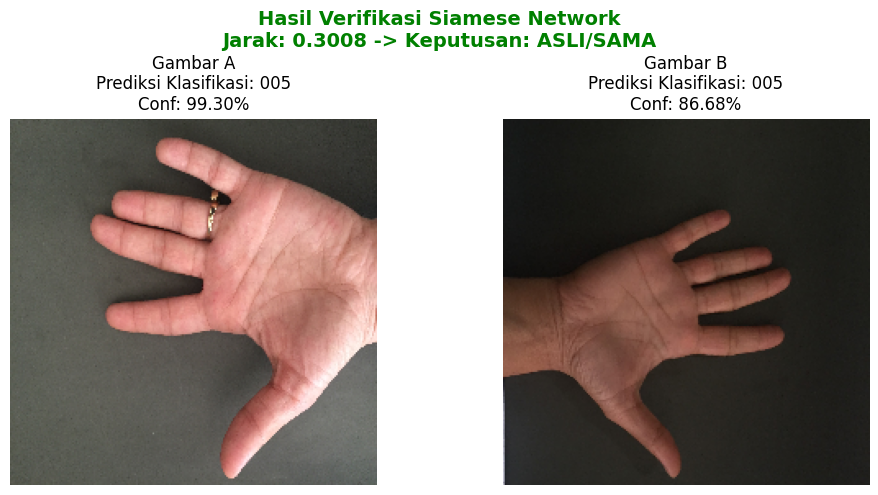

In [28]:
# orang yang sama dengan tangan yang sama
file_1 = r"Dataset_BMPD\005\005_F_L_30.JPG" 
file_2 = r"Dataset_BMPD\005\005_F_L_35.JPG"

analisis_lengkap(file_1, file_2)
# orang yang berbeda 
file_3 = r"Dataset_BMPD\001\001_F_L_30.JPG"
file_4 = r"Dataset_BMPD\002\002_F_R_5.JPG" 

analisis_lengkap(file_3, file_4)
#orang sama beda sisi tangan , tangan kanan dan kiri
file_5 = r"Dataset_BMPD\005\005_F_L_30.JPG"
file_6 = r"Dataset_BMPD\005\005_F_R_1.JPG"

analisis_lengkap(file_5, file_6)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ==========================================
# BAGIAN 1: PERSIAPAN DATA IDENTITAS
# ==========================================

# 1. Ambil peta label dari generator (Mapping Angka -> ID Folder)
label_map = (train_generator.class_indices)
label_inv = {v: k for k, v in label_map.items()}

print("1. Mapping Label Selesai.")

# 2. Database Data Diri (Simulasi Profil)
# Kita buat data dummy agar outputnya terlihat seperti sistem nyata
database_profil = {
    '001': {'nama': 'Andi Pratama', 'jabatan': 'Mahasiswa', 'usia': 21},
    '002': {'nama': 'Budi Santoso', 'jabatan': 'Dosen', 'usia': 45},
    '003': {'nama': 'Citra Kirana', 'jabatan': 'Staf Admin', 'usia': 28},
    '004': {'nama': 'Dewi Lestari', 'jabatan': 'Mahasiswa', 'usia': 20},
    '005': {'nama': 'Eko Kurniawan', 'jabatan': 'Laboran', 'usia': 35},
}

# Auto-Generate untuk sisa orang (agar ID 006 s/d 041 punya nama juga)
nama_depan = ["Fajar", "Gita", "Hendra", "Indah", "Joko", "Kartika", "Lina", 
              "Made", "Nurul", "Oscar", "Putri", "Rizky", "Siti", "Tono", 
              "Umar", "Vina", "Wahyu", "Xavier", "Yeni", "Zainal"]
jabatan_list = ["Mahasiswa", "Dosen", "Staf", "Satpam", "Tamu"]

# Loop mengisi ID yang belum ada namanya
all_labels = list(label_inv.values()) 
for label_id in all_labels:
    if label_id not in database_profil:
        random_nama = f"{random.choice(nama_depan)} {random.choice(nama_depan)}"
        database_profil[label_id] = {
            'nama': random_nama,
            'jabatan': random.choice(jabatan_list),
            'usia': random.randint(19, 60)
        }

print("2. Database Profil Penduduk Siap.")


# ==========================================
# BAGIAN 2: FUNGSI UTAMA (SISTEM PENGENALAN)
# ==========================================

def cek_identitas_lengkap(file_path):
    """
    Fungsi All-in-One: Prediksi Gambar -> Ambil Data Diri -> Tampilkan Visual
    """
    try:
        # --- A. PREPROCESSING ---
        img_asli = load_img(file_path) # Untuk visualisasi
        img_model = load_img(file_path, target_size=(224, 224)) # Untuk masuk ke AI
        
        x = img_to_array(img_model)
        x = x / 255.0  # Normalisasi (0-1)
        x = np.expand_dims(x, axis=0) # Batch dimension

        # --- B. PREDIKSI ---
        prediksi = model_clf.predict(x)
        idx = np.argmax(prediksi)          # Ambil index probabilitas tertinggi
        confidence = np.max(prediksi) * 100 # Persentase keyakinan
        
        # Terjemahkan Index ke ID (misal: "001")
        id_folder = label_inv[idx]
        
        # --- C. AMBIL DATA DARI DATABASE ---
        info = database_profil.get(id_folder, {'nama': 'Unknown', 'jabatan': '-', 'usia': '-'})
        
        # --- D. VISUALISASI HASIL ---
        plt.figure(figsize=(10, 5)) # Ukuran kanvas
        
        # Kiri: Gambar Telapak Tangan
        plt.subplot(1, 2, 1)
        plt.imshow(img_asli)
        plt.axis('off')
        plt.title("Input Citra", fontweight='bold')
        
        # Kanan: Kartu Identitas
        plt.subplot(1, 2, 2)
        plt.axis('off')
        
        # Tentukan warna status (Hijau jika yakin, Oranye jika ragu)
        color_status = 'green' if confidence > 80 else 'darkorange'
        status_text = "VERIFIED IDENTITY" if confidence > 80 else "LOW CONFIDENCE"
        
        # Format Teks Laporan
        info_text = (
            f"SISTEM BIOMETRIK TELAPAK TANGAN\n"
            f"===============================\n\n"
            f"ID PENGGUNA : {id_folder}\n"
            f"NAMA        : {info['nama']}\n"
            f"JABATAN     : {info['jabatan']}\n"
            f"USIA        : {info['usia']} Tahun\n\n"
            f"-------------------------------\n"
            f"Tingkat Kecocokan: {confidence:.2f}%"
        )
        
        # Menampilkan Teks di Plot
        plt.text(0.05, 0.5, info_text, fontsize=12, fontfamily='monospace', va='center')
        
        # Cap Status
        plt.text(0.05, 0.15, status_text, fontsize=16, color=color_status, fontweight='bold', 
                 bbox=dict(facecolor='white', edgecolor=color_status, boxstyle='round,pad=0.5'))

        plt.tight_layout()
        plt.show()
        
        print(f">> [LOG SISTEM] Deteksi Selesai: {info['nama']} ({id_folder})")
        
    except Exception as e:
        print(f"Error: Gagal memproses gambar.\nDetail: {e}")

# ==========================================
# CONTOH PENGGUNAAN
# ==========================================
# Masukkan path gambar test di sini
# path_test = r"Dataset_BMPD\001\001_F_L_30.JPG" 
# cek_identitas_lengkap(path_test)

1. Mapping Label Selesai.
2. Database Profil Penduduk Siap.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


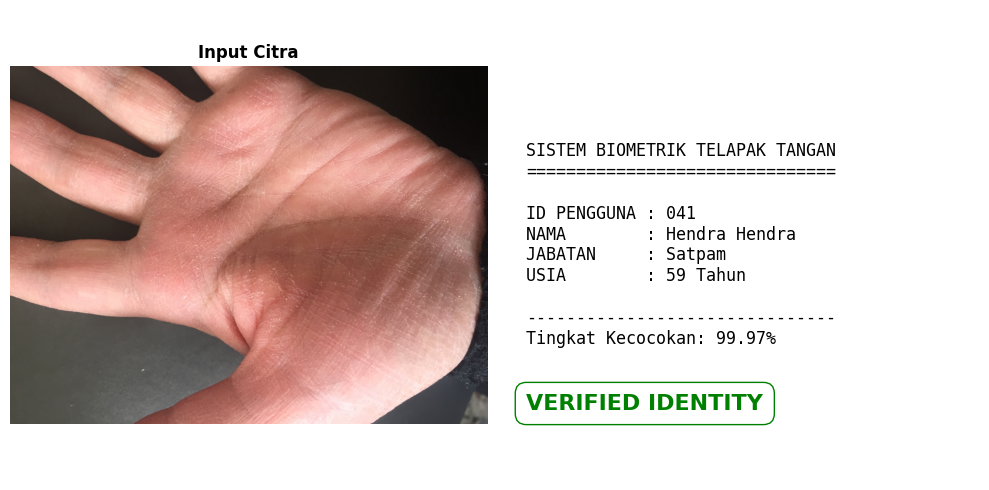

>> [LOG SISTEM] Deteksi Selesai: Hendra Hendra (041)


In [49]:
# Ganti dengan path file yang ada di laptop Anda
file_tes = r"Dataset_BMPD\041\041_F_L_32.JPG"

cek_identitas_lengkap(file_tes)